# Histograma Puntos Visitante
## Extracción, Transformación y Carga

###JOSE LÓPEZ GALDÓN

09-12-2020

***

### PLANTEAMIENTO

El objetivo es realizar un histograma con SPARK de la variable puntos de visitante.

Para ello es necesario que:

* Cargar los datos en un rdd como vimos en la última clase 

* Aplicar el método map con una función split en su interior para separar por comas

* Seleccionar el elemento del vector generado que hace referencia a los puntos visitantes y transformar a numérico

* Filtrar aquellos casos que no sean 

* Aplicar una función map que transforme cada número en uno de los intervalos del histograma (elegidos por vosotros mismos)

  *Nota: Todas las funciones map se pueden resumir en una.*

* Método de agrupación para generar un vector formado por cada elemento asociado a cada intervalor

* Función map para hacer un len y sacar el histograma

***

## Cargamos las librerías

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

## Iniciamos pySpark

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

***

## Cargamos la base de datos

In [3]:
  # Para ello utilizaremos el importador de google colaboratory
from google.colab import files
files.upload()

Saving partidosLigaNBA.csv to partidosLigaNBA.csv


{'partidosLigaNBA.csv': b'Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1\r\nTue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96\r\nTue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93\r\nTue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106\r\nWed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74\r\nWed, Oct 31, 2007:"8:30 pm":Seattle SuperSonics:103:Denver Nuggets:120\r\nWed, Oct 31, 2007:"7:00 pm":Washington Wizards:110:Indiana Pacers:119\r\nWed, Oct 31, 2007:"7:00 pm":San Antonio Spurs:104:Memphis Grizzlies:101\r\nWed, Oct 31, 2007:"7:30 pm":Chicago Bulls:103:New Jersey Nets:112\r\nWed, Oct 31, 2007:"7:00 pm":Sacramento Kings:90:New Orleans Hornets:104\r\nWed, Oct 31, 2007:"7:00 pm":Milwaukee Bucks:83:Orlando Magic:102\r\nWed, Oct 31, 2007:"7:00 pm":Philadelphia 76ers:97:Toronto Raptors:106\r\nThu, Nov 1, 2007:"8:00 pm":Detroit Pistons:91:Miami Heat:80\r\nThu, Nov 1, 2007:"7:30 pm":Phoenix Suns:106:Seattle

Una vez tenemos el dataset subido, lo siguiente será abrirlo con Spark

In [4]:
  # Establecemos la ruta del archivo
file_loc = 'partidosLigaNBA.csv'

  # Cargamos los datos
NBA = sc.textFile(file_loc)

  # Visualizamos los datos para ver si está bien con take()
NBA.take(10)

['Date:Start..ET.:Visitor.Neutral:PTS:Home.Neutral:PTS.1',
 'Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
 'Wed, Oct 31, 2007:"8:30 pm":Seattle SuperSonics:103:Denver Nuggets:120',
 'Wed, Oct 31, 2007:"7:00 pm":Washington Wizards:110:Indiana Pacers:119',
 'Wed, Oct 31, 2007:"7:00 pm":San Antonio Spurs:104:Memphis Grizzlies:101',
 'Wed, Oct 31, 2007:"7:30 pm":Chicago Bulls:103:New Jersey Nets:112',
 'Wed, Oct 31, 2007:"7:00 pm":Sacramento Kings:90:New Orleans Hornets:104']

Como podemos observar tenemos un *header* en los datos que no nos interesa, es por eso que lo eliminaremos con una función `lambda`.


In [5]:
  # Definimos nuestra función
header = NBA.filter(lambda x: "PTS" in x).filter(lambda x: "Playoffs" in x)

In [6]:
  # Eliminamos el header
NBA_no_header = NBA.subtract(header)

In [7]:
  # Comprobamos cargando las primeras 5 filas
NBA_no_header.take(5)

['Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
 'Wed, Oct 31, 2007:"7:30 pm":Chicago Bulls:103:New Jersey Nets:112',
 'Thu, Nov 1, 2007:"8:00 pm":Detroit Pistons:91:Miami Heat:80',
 'Thu, Nov 1, 2007:"7:30 pm":Phoenix Suns:106:Seattle SuperSonics:99',
 'Fri, Nov 2, 2007:"7:00 pm":Detroit Pistons:116:Orlando Magic:92']

Como podemos observar ya no tenemos el header

***

## Data Parsing

Data parsing es un método en el que una cadena de datos se convierte en un tipo de datos diferente. Supongamos que tenemos los datos en HTML sin procesar, un parse tomará dicho HTML y lo transformará en un formato de datos más legible que se puede leer y comprender fácilmente.

In [8]:
  # Importamos la librería re
import re

In [9]:
  # Parseamos los datos para leerlos 
def parse_log(line):
    match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+\s\S+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+\s\S+)\:(\d+)',line)
    if match is None:
        return (line, 0)
    else:
        return (line, 1)

In [10]:
  # Comprobamos si la función da errores...
parse_log('Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74')

('Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74', 1)

In [11]:
def map_log(line):
    match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+\s\S+)\:(\d+)\:(\D+)\:(\d+)',line)
    if match is None:
        match = re.search('^(\w+[,]\s\w+\s\S+\s\S+)\:"(\S+\s\w+)"\:(\D+)\:(\d+)\:(\D+\s\S+)\:(\d+)',line)
    return(match.groups())

  # Creamos el rrd parsed
par_rrd = NBA.map(lambda line: parse_log(line)).filter(lambda line: line[1] == 1).map(lambda line : line[0])
par_def = par_rrd.map(lambda line: map_log(line))

In [12]:
  # Comprobamos si está bien
par_rrd.take(10)

['Tue, Oct 30, 2007:"7:30 pm":Utah Jazz:117:Golden State Warriors:96',
 'Tue, Oct 30, 2007:"7:30 pm":Houston Rockets:95:Los Angeles Lakers:93',
 'Tue, Oct 30, 2007:"7:00 pm":Portland Trail Blazers:97:San Antonio Spurs:106',
 'Wed, Oct 31, 2007:"8:00 pm":Dallas Mavericks:92:Cleveland Cavaliers:74',
 'Wed, Oct 31, 2007:"8:30 pm":Seattle SuperSonics:103:Denver Nuggets:120',
 'Wed, Oct 31, 2007:"7:00 pm":Washington Wizards:110:Indiana Pacers:119',
 'Wed, Oct 31, 2007:"7:00 pm":San Antonio Spurs:104:Memphis Grizzlies:101',
 'Wed, Oct 31, 2007:"7:30 pm":Chicago Bulls:103:New Jersey Nets:112',
 'Wed, Oct 31, 2007:"7:00 pm":Sacramento Kings:90:New Orleans Hornets:104',
 'Wed, Oct 31, 2007:"7:00 pm":Milwaukee Bucks:83:Orlando Magic:102']

In [13]:
  # Comprobamos el par_def
par_def.take(5)

[('Tue, Oct 30, 2007',
  '7:30 pm',
  'Utah Jazz',
  '117',
  'Golden State Warriors',
  '96'),
 ('Tue, Oct 30, 2007',
  '7:30 pm',
  'Houston Rockets',
  '95',
  'Los Angeles Lakers',
  '93'),
 ('Tue, Oct 30, 2007',
  '7:00 pm',
  'Portland Trail Blazers',
  '97',
  'San Antonio Spurs',
  '106'),
 ('Wed, Oct 31, 2007',
  '8:00 pm',
  'Dallas Mavericks',
  '92',
  'Cleveland Cavaliers',
  '74'),
 ('Wed, Oct 31, 2007',
  '8:30 pm',
  'Seattle SuperSonics',
  '103',
  'Denver Nuggets',
  '120')]

In [14]:
  # Tipo del objeto anterior
type(par_def)

pyspark.rdd.PipelinedRDD

***

## Creación del dataframe para el histograma

In [15]:
  # Generamos una muestra sin reemplazamiento
muestra = sc.parallelize(par_def.takeSample(False, 1200))

In [16]:
  # Función para estirar los datos
def convert_long(x):
    x = re.sub('[^0-9]',"",x) 
    if x =="":
        return 0
    else:
        return int(x)

  # Aplicamos la función a nuestra muestra
muestra_long = muestra.map(lambda line: convert_long(line[3])).collect()

In [17]:
  # Ordenamos la muestra
muestra_long.sort()

In [18]:
  # Vemos el resultado
muestra_long

[62,
 64,
 65,
 67,
 68,
 69,
 70,
 70,
 71,
 71,
 72,
 72,
 72,
 72,
 72,
 74,
 74,
 74,
 74,
 74,
 75,
 75,
 75,
 75,
 75,
 75,
 76,
 76,
 76,
 77,
 77,
 77,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 78,
 79,
 79,
 79,
 79,
 79,
 79,
 79,
 79,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 80,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 81,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 82,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 83,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 84,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 85,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 86,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,
 87,


Una vez tenemos nuestra muestra definida y ordenada, generaremos los deciles para el histograma.

In [19]:
  # Nos definimos un objeto con el dataset anterior seleccionando los deciles (10% de los datos, el 20%, el 30%...)
deciles = [muestra_long[int(len(muestra_long) * .10)-1],
           muestra_long[int(len(muestra_long) * .20)-1],
           muestra_long[int(len(muestra_long) * .30)-1],
           muestra_long[int(len(muestra_long) * .40)-1],
           muestra_long[int(len(muestra_long) * .50)-1],
           muestra_long[int(len(muestra_long) * .60)-1],
           muestra_long[int(len(muestra_long) * .70)-1],
           muestra_long[int(len(muestra_long) * .80)-1],
           muestra_long[int(len(muestra_long) * .90)-1],
           muestra_long[-1]]
deciles

[84, 89, 94, 97, 99, 102, 105, 109, 114, 154]

Nuestros deciles serán:
*83, 88, 92, 95, 98, 101, 104, 108, 114, 140*

In [20]:
  # Definimos una función que nos clasifique las observaciones según el decil correspondiente
def decilHistograma(x):
    if x <= deciles[5]:
        if x > deciles[4]:
            return(6)
        elif x > deciles[3]:
            return(5)
        elif x > deciles[2]:
            return(4)
        elif x > deciles[1]:
            return(3)
        elif x > deciles[0]:
            return(2)
        else:
            return(1)
    else:
        if x <= deciles[6]:
            return(7)
        if x <= deciles[7]:
            return(8)
        if x <= deciles[8]:
            return(9)
        if x <= deciles[9]:
            return(10)
        else:
            return(11)

In [21]:
  # Vamos a pasarle la observación 120 para ver a qué decil corresponde
decilHistograma(120)

10

In [22]:
  # Otra prueba con el 84
decilHistograma(84)

1

La función funciona correctamente. Una vez hecho esto definimos nuestras barras o bins del histograma.


In [23]:
bins = par_def.map(lambda line : convert_long(line[3])).map(lambda x : (decilHistograma(x),1)).reduceByKey(lambda a, b: a + b).collect()
bins

[(10, 1250),
 (4, 1246),
 (8, 1216),
 (2, 1390),
 (6, 1188),
 (3, 1870),
 (7, 1186),
 (9, 1136),
 (1, 1512),
 (5, 903)]

In [24]:
  # Transformamos a DF el objeto bins
hist_data = pd.DataFrame(bins)
hist_data

,0,1
0,10,1250
1,4,1246
2,8,1216
3,2,1390
4,6,1188
5,3,1870
6,7,1186
7,9,1136
8,1,1512
9,5,903


***

## Histograma

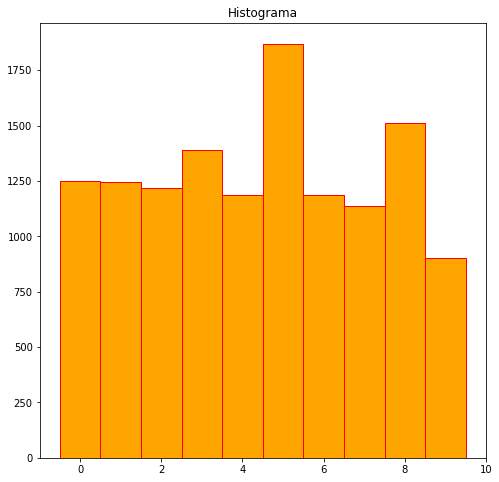

In [25]:
  # Definimos los parámetros del histograma
labels, ys = zip(*bins)
xs = np.arange(len(labels)) 
width = 1

  # Tamaño de la figura
f, ax = plt.subplots(figsize=(8, 8))

  # Ploteamos la figura
plt.bar(xs, ys, width, align='center', color = "orange", ec = "red");
plt.title("Histograma");


In [26]:
  # Finalizamos spark
sc.stop()



---





---

